<table>
    <tr style="background-color:#FFFFFF;">
        <td> 
            <a href="https://www.kineticmind.de">
                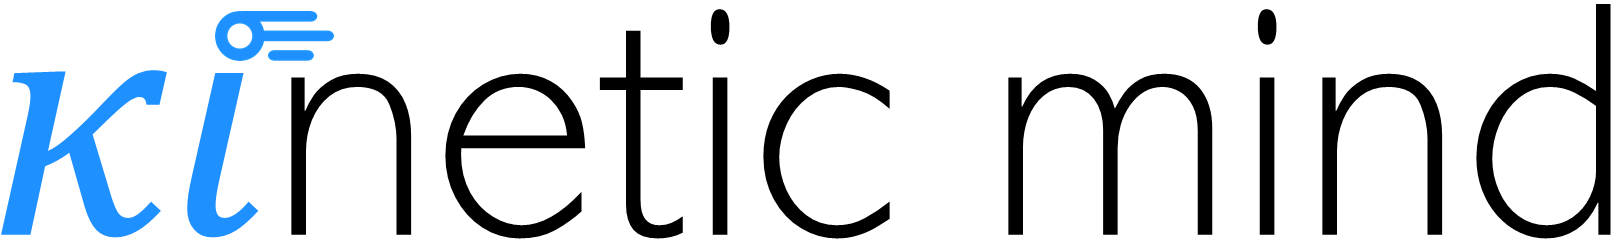
            </a>
        </td>
    </tr>
    <tr style="background-color:#FFFFFF;">
        <td> 
            <a href="https://www.rivacon.com">
                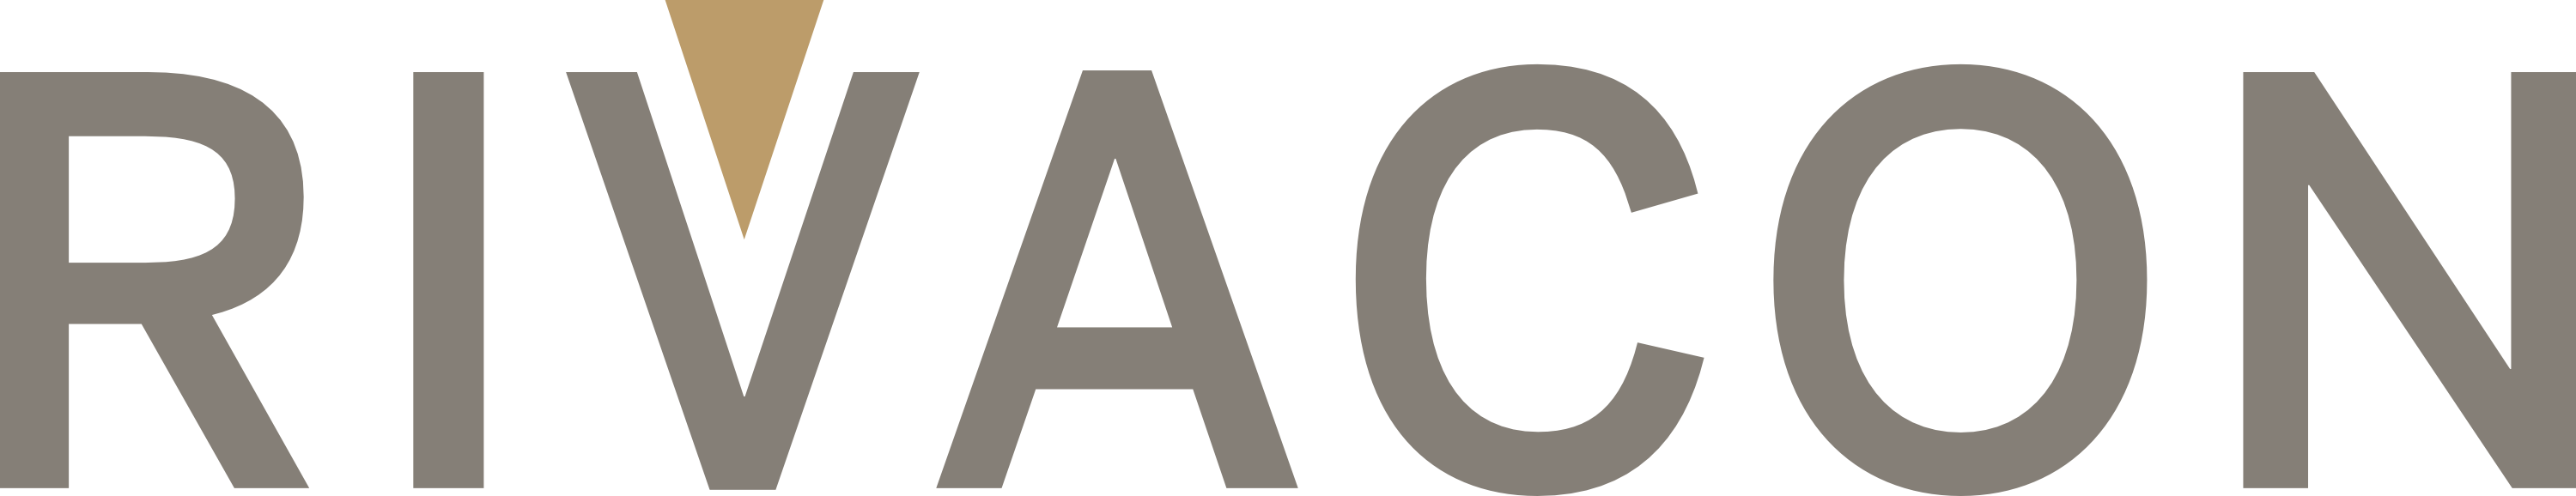
            </a>
        </td>
    </tr>
</table>

# Deep Hedging

This notebook demonstrates how a neural network can be used to find a dynamic hedging strategy for a call option. One of the first contributions to this topic with regard to deep neural networks is the paper
[Deep Hedging](https://arxiv.org/abs/1802.03042) by Buehler, Gonon, Teichmann and Wood.

In order to keep the computations feasible on a computer with no dedicated hardware for high performance computing, we use standard dense neural networks (DNN). These are applied at every time step where the hedge is adapted, but do not allow to pass learned information from one time step to the next. It is demonstrated below that for simple instruments like a call DNNs work very well. This is not suprising, since Black-Scholes theory tells that a vanilla option can be perfectly hedged by the negative delta position $-\Delta(t,S_t)$, which does not depend on any past information either.

Most of the implementations in the literature that investigate more complex market setups (like the one cited above) use recurrent neural networks (RNNs), which are much more flexible, since they allow to pass information in time direction too, but are much more time consuming to calibrate too.

We investigate the problem of hedging a vanilla call with payoff
$$
\max(S_T-K,0)
$$
where $S_t$ denotes the spot at time $t$, $K$ is the strike and $T$ the expiry. The underlying can be traded with a bid-ask spread $\delta$, defined relative to the spot $S$, i.e. buying the underlying costs
$$S_{ask}= S\cdot (1.0+0.5\cdot \delta),$$
and selling it yields 
$$S_{bid}= S\cdot(1.0-0.5\cdot \delta).$$
The underlying price $S_t$ is modeled by a geometric Brownian motion and we assume zero interest rates, borrow rates and dividends, respectively.

In [1]:
# Before we can really start, we import all necessary modules
import os
import scipy.stats as stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

%matplotlib inline

## Global Settings
<a id='global_settings'></a>

In [2]:
vol = 0.2 #volatility of GBM
strike = 100.0 # Call strike
spot = 100.0 # initial spot
ba_spread = 0.01 # bid-ask spread
ttm = 1.0 # time to maturity (equals T in the formula above)

## Problem formulation and network achitecture

For hedging the call option, we have to find hedge quantities $q_i = q(t_i, S_{t_i}, \ldots)$ that determine the position in the underlying such that the portfolio becomes risk free. In theory, setting up the portfolio generates an initial cash flow (the price of the call option) and any subsequent adaption following the optimal hedging strategy is self financing, meaning an internal re-weighting of the cash and hedge positions in the portfolio consisting of the call option, the position in the underlying and the cash position.

In practice, we need to deal with at least two imperfections: firstly, continuous trading is not feasible in reality, and, secondly, real world markets have transaction costs. The goal is to identify a function $q(t, S_t, \ldots)$, such that the portfolio is optimally hedged with respect to some loss function. The dots ("$\ldots$") indicate that any known information can be used as input for the loss function, not only the hedge time and the spot value.

The steps to estimate this hedge function $q$ by means of neural networks are the following:
* Define a time discretization $0=t_0<...<t_{N-1}<t_N=T$ covering the remaining lifetime of the option, i.e. starting with $t_0$ as today and ending with $t_N$, the expiry of the option.
* Generate simulted spot paths $S_j=(S_{i,j})_{0\le i \le N}$ where $S_{i,j}$ denotes the spot price of the $j$-th simulated path at time $t_i$.
* Determine a loss function $L$ defined on the cumulated cash flows at the hedge times, defining the P&L of the portfolio. Typical examples of loss functions minimize the variance or the expexted shortfall of the P&L.

The general optimization problem can now be described by
$$
q^* (t,S) = {\rm arg} \min _{\hspace{-0.7cm} q} L\bigl(\sum_{i=0}^{N} {\rm cash flow}(q(t_i,S_{t_i},\ldots))\bigr).
$$

It is worth being more specific about the cash flows that are computed for the hedge times from $t_0$ to $t_N$ and used to compute the P&L for optimization.

Although the simulated spot paths are computed from a single parametrization of a Black-Scholes model (to keep the code simple), __it is important to ensure that the cash flows are model free__, which means they do not involve any computations that depend on a financial model (like the Black-Scholes model).
In our implementation here the cash flows consist of the gain/loss of trading the underlying and the payoff of the option at expiry. Other model-free cash flows could be (deterministic) dividend and interest rate payments, or cash flows from actions like executing an american option.

The initial price of the call option is definitely not model-free, and therefore not considered as cash-flow in the P&L calculation. As a consequence, the level of the optimized portfolio P&L (using $q^*$) will be close to the "fair value" of the call. 

Generally speaking, the described procedure can be used to get an idea of a fair value for an derivative that has to be hedged in imperfect markets.

The requirement of using model-free cash flows does not prevent us from using model-dependent input variables for the hedge quantity function $q(t, S_t, \ldots)$. The final hedge quantities will be determined by the neural network, and, for instance, even if the optimal hedge quantities do not follow a BS delta, the BS delta as input may serve as a baseline for the optimal hedges, helping to stabilize the optimal hedge quantities.

The DNN based network architecture is summarized by this graphics:
<img src="images/deep_hedging_tdnn.png" alt="Drawing" style="width: 600px;"/>




### Regularization

One possible way to enhance performance of AI models is to incldue some domain knowlege into the training process or architecture. In the case of hedging one reasonable assumption for a call option is that the hedge quantity (delta) should be monotonically increasing with increasing spot. To achieve this, the network creation below includes a regularization layer that penalizes negative derivatives w.r.t. input spots (computed with tensorflows *GradientTape*). 

### Black-Scholes Delta as Baseline

The code below does also allow to use a precomputed Black-Scholes delta as baseline, i.e. the neural network is trained to just correct the Black-Scholes delta.

### Network creation

In [3]:
class GradientRegularizationLayer(tf.keras.layers.Layer):
    """Layer to penalize negative deltas.
    """
    def __init__(self, reg_factor, **kwargs):
        
        super(GradientRegularizationLayer, self).__init__(**kwargs)

        self.reg_factor = reg_factor

        self.grad_penalty = tf.keras.layers.Lambda(lambda x: self.reg_factor * tf.keras.backend.maximum(x, 0.0))
            
    def call(self, inputs):
        
        reg_loss = self.grad_penalty(inputs)
        self.add_loss(tf.reduce_sum(reg_loss))
        
        return inputs

    def get_config(self):

        config = super(GradientRegularizationLayer, self).get_config()
        config.update({'reg_factor': self.reg_factor})

        return config


class Hedger:
    """This class encapsulates all methods needed to create the hedge model as well as the time distributed model needed to train the hedge model.
    """
    @staticmethod
    def get_hedge_model(m, name_time_distributed = None):
        """Method to extract the hedge model from the overall time distributed network

        Args:
            m (time distributed network): The time disributed network tht was used for training
            name_time_distributed (str): If specified, the name of the inner model. If not specified the default 'time_distributed/hedge_model' is used.

        Returns:
            tf.keras.model: The network representing the hedge model q
        """

        if name_time_distributed is None:
            name_time_distributed = 'time_distributed/hedge_model'
        return m.get_layer(name_time_distributed).layer
        
    
    @staticmethod
    def _create_hedge_model(n_features,
                            layers=[{'units':10, 'activation':'tanh'}, 
                                    {'units':5, 'activation':'tanh'}, 
                                    {'units':1, 'activation':'linear'}
                                   ]):
        """Method to create the network for the hedge model q
        
        Args:
            n_features (int): Number of features
            layers (list of dict): List of layers used for the network contruction.
        """
        hedge_input_feat = tf.keras.layers.Input(shape=(n_features), ragged=False, name='hedge_input')
        previous = tf.keras.layers.Dense(name='hedge_model_0', **layers[0])(hedge_input_feat)
        for k in range(1, len(layers)):
            if k < len(layers)-1:
                name = 'hedge_model_'+str(k)
            else:
                name = 'hedge_qty'
            previous = tf.keras.layers.Dense(name = name, **layers[k])(previous)
        return tf.keras.models.Model(name = 'hedge_model', inputs=hedge_input_feat, 
                              outputs=previous)
        return previous
        
    @staticmethod
    def create_model(n_times, 
                     n_features,
                     model_type='plain',
                     layers=[{'units':10, 'activation':'tanh'},
                             {'units':5, 'activation':'tanh'},
                             {'units':1, 'activation':'linear'}
                            ],
                     reg_factor=100.0
                    ):
        """Create the time distributed network used to train the hedge model.
        
        Args:
            n_times (int): Number of time steps
            layers (list of dict): List of layers used for the network contruction of th hedge model q.
            model_type: Demonstration of different model types. Implemented are:
                        'plain': standard dense neural network
                        'deltabase': gives the Black Scholes delta as input and as baseline
                        'gradreg': penalizes positive gradients of the hedge quantities with respect
                                   to the spot, since a long call position should have negative gradients.
        """

        # create hedge model
        # 
        hedge_input_feat = tf.keras.layers.Input(shape=(n_times-1, n_features))
        
        hedge_model = Hedger._create_hedge_model(n_features, layers)
        if model_type == 'plain':
            hedge_qty = tf.keras.layers.TimeDistributed(hedge_model,
                                                        name='time_distributed/hedge_model'
                                                       )(hedge_input_feat)
            
        elif model_type == 'deltabase':
            input_base = tf.keras.layers.Input(shape=(n_times-1, 1))
            delta_adjustment = tf.keras.layers.TimeDistributed(hedge_model,
                                                        name='time_distributed/hedge_model'
                                                       )(hedge_input_feat)
            hedge_qty = tf.keras.layers.Add()([delta_adjustment, input_base])
            
        elif model_type == 'gradreg':
            with tf.GradientTape() as grad:
                grad.watch(hedge_input_feat)
                hedge_qty = tf.keras.layers.TimeDistributed(hedge_model, 
                                                            name='time_distributed/hedge_model'
                                                           )(hedge_input_feat)

            # Since the position to be hedged is a "long call", the gradients of the hedge quantity (delta)
            # with respect to the spot has to be non-positive at all times and spot values
            #
            hedge_qty_grad_all = grad.gradient(hedge_qty, hedge_input_feat)
            hedge_qty_grad = tf.keras.layers.Lambda(lambda x: x[:,:,0])(hedge_qty_grad_all)
            grad_penalty = GradientRegularizationLayer(reg_factor, name='gradient_penalty')(hedge_qty_grad)

        else:
            raise ValueError('Unknown model type ' + str(model_type) + '.')
        
                    
        # In our example, the loss function in the training will be applied the PnL of the hedging strategy on each path.
        # The PnL computation is done in the following lines.
        #
        cf_input_spot_bid = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_bid')
        cf_input_spot_ask = tf.keras.Input(shape=(n_times,1) ,name='CF_input_spot_ask')
        
        cf_input_inst_payoff = tf.keras.Input(shape=(n_times,1) ,name='CF_input_call_payoff')
        cf_input_df = tf.keras.Input(shape=(n_times,1) ,name='CF_input_df')

        # hedge cashflows from trades
        cf_dqty_inner = tf.keras.layers.Lambda(lambda x: x[:,1:] - x[:,:-1])(hedge_qty)
        cf_dqty0 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(x[:,0,:], shape=(-1,1,1)))(hedge_qty)
        cf_dqtyT = tf.keras.layers.Lambda(lambda x: tf.keras.backend.reshape(-x[:,-1,:], shape=(-1,1,1)))(hedge_qty)
        cf_dqty = tf.keras.layers.Concatenate(axis=1)([cf_dqty0, cf_dqty_inner, cf_dqtyT])

        cf_dqty_pos = tf.keras.layers.Lambda(lambda x: tf.keras.backend.minimum(-1.0*x, 0.0))(cf_dqty)
        cf_dqty_neg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.maximum(-1.0*x, 0.0))(cf_dqty)

        cf_hedge_cashflow_buy = tf.keras.layers.Multiply()([cf_dqty_pos, cf_input_spot_ask])
        cf_hedge_cashflow_sell = tf.keras.layers.Multiply()([cf_dqty_neg, cf_input_spot_bid])
        cf_hedge_cashflow = tf.keras.layers.Add(name='CF_hedge_cashflow_trades')([cf_hedge_cashflow_buy, cf_hedge_cashflow_sell])

        # all cashflows collected
        # discounted cashflow defines the loss
        cf_loss_timestep = tf.keras.layers.Multiply(name='CF_cashflows_discounted')([cf_input_df, cf_hedge_cashflow])
        # aggregate loss output (over time steps)
        cf_loss_value = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1, keepdims=True), name='loss')(cf_loss_timestep)
         
        # return total model
        inputs = [hedge_input_feat, cf_input_spot_bid, cf_input_spot_ask, cf_input_df]
        if model_type == 'deltabase':
            inputs.append(input_base)

        return tf.keras.models.Model(inputs=inputs, outputs=cf_loss_value)

## Generating Input Data

As we have described above we need the following inputs:

- $S=(S_{i,j})$ as the simulated spots (here $i$ denotes the number of path and $j$ the timepoint)
- $S_{ask,i,j}= S_{i,j}\cdot (1.0+0.5\cdot \delta)$ and $S_{bid,i,j}= S_{i,j}\cdot(1.0-0.5\cdot \delta)$ where $delta$ can be configured in the [Global Settings](#global_settings) section
- The time-to-maturity as input into the neural network
- The final payoff $p_i$ of the Call option for each path $j$
- Discount factors for each time point
- For a neural network model that only corrects the delta from the Black-Scholes model (we use delta as a baseline) we additionally needed the respective deltas $\delta_{i,j}$ for each path

### Helper functions

In [5]:
def compute_bs(spot, strike, ttm, sigma, r=0.0):
    """ Compute call option price and delta with Black-Scholes formula.
    Args:
        spot (float): Spot
        strike (float): Strike
        ttm (float): Remainin tme to maturity
        sigma (float): Volatility
        r (float): interest rate
    """
    d1 = ( np.log(spot / strike) + (r + 0.5*sigma**2) * ttm ) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    price = spot * stats.norm.cdf(d1) - np.exp(-r * ttm) * strike * stats.norm.cdf(d2)
    delta = stats.norm.cdf(d1)
    return price, delta

def compute_data(ttm, n_timesteps, n_samples, final_payoff, vol, spot, ba_spread, strike):
    """ This method simulates bid-ask spot paths using geometric brownian motion and returns 
    the path together with the evaluation of a given payoff at the final simulation date.
    Args:
        ttm (float): The time-to-maturity of the simulation
        n_timesteps (int): Number of timesteps used to simulate the paths
        n_samples (int): Number of monte carlo simulations
        final_payoff (function): Function that is evaluated at the final spot values
        vol: The volatility of the geometric brownian motion (annualized)
        ba_spread: Bid-ask spread as percentage, i.e. spot_bid = spot*(1.0-ba_spread*0.5)
        strike (float): Strike of respective call
        
    Returns:
        [3D numpy-array]: The spot bid value
        [3D numpy-array]: The spot ask value
        [3D numpy-array]: Timegrid (of time-to-maturities)
        [3D numpy-array]: Evaluated payoff (at maturity)
        [3D numpy-array]: Delta at the respective time step for the respective mid-spot
    """
    spot_bid = np.empty((n_samples, n_timesteps,))
    spot_ask = np.empty((n_samples, n_timesteps,))
    delta = np.empty((n_samples, n_timesteps,))
    payoff = np.zeros((n_samples,))
    timegrid = np.linspace(0.0, ttm, n_timesteps)
    call_ttm = np.empty((n_samples, n_timesteps,))
    simulated_spot = np.full((n_samples,), spot)
    spot_bid[:,0] = simulated_spot*(1.0-ba_spread*0.5)
    spot_ask[:,0] = simulated_spot*(1.0+ba_spread*0.5)
    
    for i in range(n_samples):
        call_ttm[i,:] = ttm-timegrid
    
    vol_2 = vol**2
    for i in range(1,timegrid.shape[0]):
        dt = timegrid[i]-timegrid[i-1]
        rand = np.random.standard_normal((n_samples,))
        simulated_spot = simulated_spot * np.exp((- 0.5 * vol_2) * dt +
                                         vol * np.sqrt(dt) * rand)
        spot_bid[:,i] = simulated_spot*(1.0-ba_spread*0.5)
        spot_ask[:,i] = simulated_spot*(1.0+ba_spread*0.5)
        _,delta[:,i] = compute_bs(simulated_spot, strike, ttm-timegrid[i-1], vol)
    payoff[:] = final_payoff(simulated_spot)
    return np.atleast_3d(spot_bid), np.atleast_3d(spot_ask), np.atleast_3d(call_ttm), payoff, np.atleast_3d(delta) # for later usage in the time distributed NN we must apply np.atleast_3d

def call_payoff(strike):
    """Defines the call payoff function for a call with strike strike.
    """
    def c(x):
        return np.maximum(x-strike, 0.0)
    return c


### Create Data

In [6]:
np.random.seed(42)
spot_bid, spot_ask, call_ttm, payoff, delta = compute_data(ttm, n_timesteps=120, n_samples=20000, 
                                                    final_payoff=call_payoff(strike=strike), vol=vol, 
                                                    spot=spot, ba_spread=ba_spread,strike=strike)

f_hedge=np.concatenate([(spot_bid+spot_ask)/(2.0*strike), call_ttm], axis=2) #the input for the neural network constructed later
df = np.ones(shape=(f_hedge.shape[0], f_hedge.shape[1], 1))# set discount factors to 1 (no discounting)

##  Loss functions

As discussed above, there are different possible loss functions $L$. In this notebok we use two different loss functions:
- Variance: We measure the variance of the hedge vs the call's PnL
- Expected Shortfall: The expected shortfall (10%) is used

In [7]:
@tf.function
def variance_loss(y_true, y_pred):
    x = tf.nn.moments(y_pred-y_true, axes=0)
    return x[1]


@tf.function
def expected_shortfall_10pct(y_true, y_pred):
    """[summary]

    Args:
        y_true ([type]): [description]
        y_pred ([type]): [description]

    Returns:
        [type]: [description]
    """
    pnl = tf.keras.backend.reshape(y_pred - y_true, (-1, ))
    pnl = tf.multiply(pnl, -1.0)

    n_pct = tf.keras.backend.round(tf.multiply(
        tf.keras.backend.cast(tf.keras.backend.shape(pnl)[0], tf.float32)  , 0.1))

    pnl_past_cutoff = tf.nn.top_k(pnl, tf.keras.backend.cast(n_pct, tf.int32))[0]
    return tf.reduce_mean(pnl_past_cutoff)

## Training

<div class="alert alert-block alert-warning">
<b>Note:</b> For the model type 'gradreg' TensorFlow is required in version 2.2 or above.
</div>

In [8]:
model_type ='gradreg' #'gradreg', 'plain', 'deltabase'

nn_hedge = Hedger.create_model(n_times=f_hedge.shape[-2], n_features= f_hedge.shape[-1], 
                               model_type=model_type, 
                               reg_factor=100.0,
                               layers = [{'units':10, 'activation':'tanh'}, 
                                         {'units':5, 'activation':'tanh'}, 
                                         {'units':1, 'activation':'linear'}])

In [9]:
nn_hedge.compile(optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999), loss = variance_loss)#'mean_squared_error')

Start training...

In [10]:
cb = [] # list of callbacks
# if you would like to use the tensorboard, uncomment the following lines 
# and adjust the directories accordingly
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'tensorboard_log/'+model_type + '/' + date
cb.append(tf.keras.callbacks.TensorBoard(profile_batch=0, 
                                        log_dir=log_dir, 
                                        histogram_freq=100))

cb.append(tf.keras.callbacks.ModelCheckpoint(log_dir + '/model_5_percent_spread.h5', save_best_only = True)) #write a model checkpoint

learning_rate = lambda epochs: 0.1 * (0.1 ** np.floor(np.log10(epochs+1)))
cb.append(tf.keras.callbacks.LearningRateScheduler(learning_rate))

x_train = [f_hedge[:,:-1,:], spot_bid, spot_ask, df]
if model_type=='deltabase': #append delta to input if we just train the network to correct the delta
    x_train.append(delta[:,:-1,:])
    
history = nn_hedge.fit(x_train, 
                    payoff,
                    verbose=0,
                    epochs=100, # the given value is too small to achieve convergence, consider setting a higher value
                    batch_size=100,
                    callbacks=cb,
                    validation_split=0.2)

## Model analysis

In this section we analyze the behaviour of the deep hedging model.

### Helper functions

In [11]:
def plot_delta_vs_spot(model, ttm, model_type):
    spots = np.arange(0.5*spot,1.5*spot, 0.01*spot)
    # compute and plot Black Scholes delta
    bs_delta = np.empty(shape=(spots.shape[0]))
    for i,s in enumerate(spots):
        _, bs_delta[i] = compute_bs(s, strike, ttm, vol, 0.0)
    plt.plot(spots,bs_delta,'.', label='Black-Scholes')
    
    # compute and plot delta from neural network
    x=np.empty(shape=(spots.shape[0], 2))
    x[:,0] = spots/strike
    x[:,1] = ttm
    delta = hedge_model.predict(x)
    if model_type=='deltabase':
        delta[:,0] = delta[:,0] + bs_delta
    plt.plot(spots,delta[:,0],'.', label=model_type) #since the above model hedges a long Call position, we have to use -delta to compare with BS delta
    
    plt.legend()
    plt.xlabel('spot')
    plt.ylabel('delta')
    plt.title('Black-Scholes vs Deep Hedging Delta for Call with ttm=' + str(ttm))
    
def plot_delta_vs_ttm(model, spot, model_type):
    ttm_ = np.arange(1.0/365.0, ttm, 1.0/365.0)
    x=np.empty(shape=(ttm_.shape[0], 2))
    # compute and plot Black Scholes delta
    bs_delta = np.empty(shape=(ttm_.shape[0]))
    for i,t in enumerate(ttm_):
        _, bs_delta[i] = compute_bs(spot, strike, t, vol, 0.0)
    plt.plot(ttm_, bs_delta,'.', label='Black-Scholes')
    # compute and plot delta from neural network
    x[:,0] = spot/strike
    x[:,1] = ttm_
    delta = hedge_model.predict(x)
    if model_type=='deltabase':
        delta[:,0] = delta[:,0] + bs_delta
    plt.plot(ttm_, delta[:,0], '.', label=model_type) 
    
    plt.legend()
    plt.xlabel('ttm')
    plt.ylabel('delta')
    plt.title('Black-Scholes vs Deep Hedging Delta for Call, spot=' + str(spot))
    


### PnL Distribution and Fair Value

In this section we plot the final PnL distribution of the portfolio consisting of the hedge strategy and the call option. Note that we define in our context the *deep hedging price* as the mean of this portfolios PnL and subtract this from the distribution (to center the distribution at zero). There are infinite other pricing measures (stemming from the incomplete nature of this problem) and it is up to you to play around and try other loss functions and measures different then the mean.

BS price: 7.965567455405804, deep-hedging price: 10.265672560950195
Mean total (hedge+instrument) pnl: 1.3940848475613167e-15
variance total (hedge+instrument) pnl: 1.1129811738201112


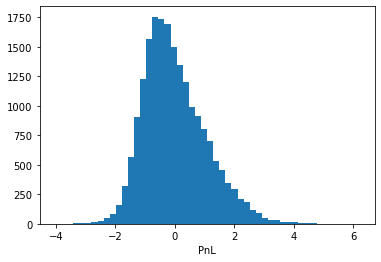

In [13]:
pnl = nn_hedge.predict([f_hedge[:,:-1,:], spot_bid, spot_ask,  df[:]])#
price = np.mean(payoff-pnl[:,0,0]) # we define the product price as the mean of hedge-portfolio difference
plt.hist(payoff-pnl[:,0,0]-price, bins=50)
plt.xlabel('PnL')

bs_price, _ = compute_bs(spot, strike, ttm, vol, 0.0)
print('BS price: ' + str(bs_price) +', deep-hedging price: ' + str(price))
print('Mean total (hedge+instrument) pnl: ' + str(np.mean(payoff-pnl[:,0,0]-price)))
print('variance total (hedge+instrument) pnl: ' + str(np.var(payoff-pnl[:,0,0])))

### Hedge Quantities (Deltas)

In [14]:
hedge_model = Hedger.get_hedge_model(nn_hedge)

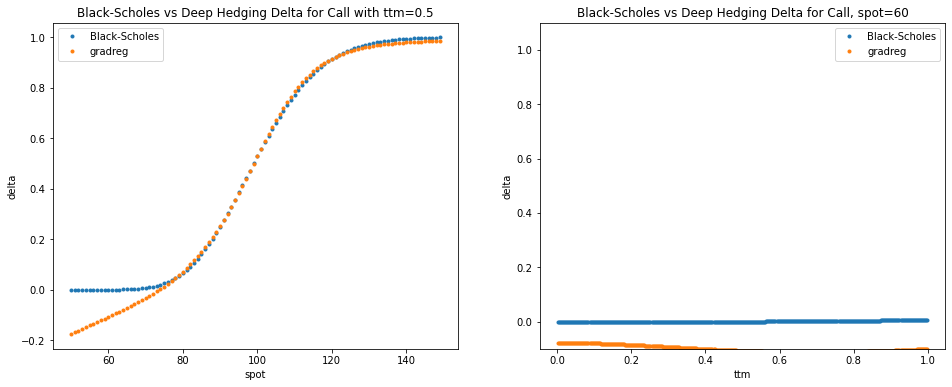

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_delta_vs_spot(hedge_model, ttm=0.5, model_type=model_type)
plt.subplot(1,2,2)
plot_delta_vs_ttm(hedge_model, spot=60, model_type=model_type)
plt.ylim((-0.1,1.1));